In [2]:
from pathlib import Path
import pandas as pd

# Get the current working directory
current_dir = Path.cwd()

# Construct the dynamic file path
file_path = current_dir  / 'data' / 'raw' / 'wire-rod-production'

# Read the CSV file
df = pd.read_csv(file_path)

df


,Ultimate Tensile Strength (UTS) (MPa),Elongation (%),Conductivity (% IACS),Aluminum Purity (%),Casting Temperature (°C),Cooling Water Temperature (°C),Casting Speed (m/min),Cast Bar Entry Temperature at Rolling Mill (°C),Emulsion Temperature at Rolling Mill (°C),Emulsion Pressure at Rolling Mill (bar),Emulsion Concentration (%),Rod Quench Water Pressure (bar)
0,104.381693,11.168725,61.757609,99.631924,693.143606,23.861783,5.149830,488.462215,38.356771,1.055611,3.186799,1.561405
1,100.504085,14.388468,61.784230,99.961697,745.741427,23.688298,5.520401,462.265515,25.115619,2.071246,3.738603,1.960230
2,105.662305,7.916694,61.602304,99.812800,723.382702,24.705562,7.590750,480.459515,33.396834,2.510906,5.508732,1.266822
3,113.361330,8.210816,61.118162,99.558000,692.085340,22.725522,4.237351,479.043231,39.223057,1.871626,6.641807,1.674357
4,103.871023,6.869438,61.636942,99.933207,681.904532,28.929490,9.555537,488.463476,26.107538,1.133919,6.104775,1.072337
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,103.877877,12.007133,61.428050,99.511432,680.929019,21.593852,6.428677,456.063729,33.495752,1.303997,6.112685,1.663234
19996,106.009268,12.359295,61.425970,99.641131,725.653704,25.608887,7.955241,464.449524,34.478332,2.882413,4.740424,1.669342
19997,91.009071,13.480313,61.913309,99.808381,687.723389,29.118798,7.289757,462.950516,24.169347,2.853713,5.862997,1.980254
19998,101.234907,13.725868,61.854378,99.514183,706.939041,21.767177,4.962030,484.505771,26.614365,2.702979,5.505449,1.158089


In [3]:
df.isnull().sum()  # Check for missing values
df.dropna(inplace=True)  # Drop rows with missing values (if needed)


In [4]:
import numpy as np
from scipy.stats import zscore

# Remove rows with Z-score > 3
df = df[(np.abs(zscore(df)) < 3).all(axis=1)]


In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the scaler
scaler = StandardScaler()

# Separate the features and the target columns
features = df[['Elongation (%)', 'Ultimate Tensile Strength (UTS) (MPa)', 'Conductivity (% IACS)']]
target_column = df['Casting Temperature (°C)']

# Scale the features
scaled_features = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)

# Add the target column back to the DataFrame without scaling it
df_scaled['Casting Temperature (°C)'] = target_column.values

# Check the result
df_scaled.head()


,Elongation (%),Ultimate Tensile Strength (UTS) (MPa),Conductivity (% IACS),Casting Temperature (°C)
0,0.403011,-0.065391,0.885364,693.143606
1,1.520905,-0.513492,0.977490,745.741427
2,-0.726093,0.082598,0.347891,723.382702
3,-0.623974,0.972306,-1.327600,692.085340
4,-1.089701,-0.124405,0.467765,681.904532


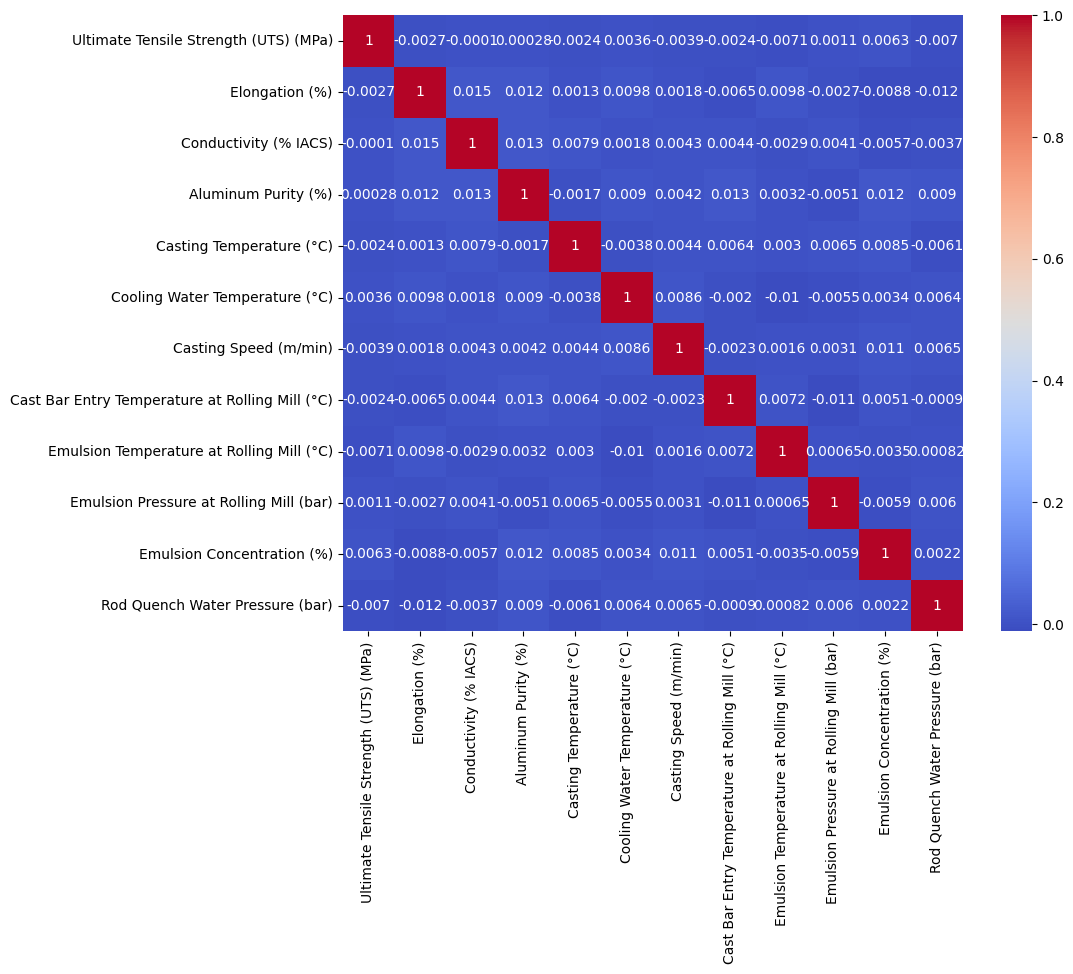

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


In [7]:
from sklearn.model_selection import train_test_split

X = df_scaled.drop(columns=['Casting Temperature (°C)'])
y = df_scaled['Casting Temperature (°C)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

2024-11-17 23:58:12.913708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731868092.932694   24434 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731868092.938340   24434 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 23:58:12.957439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
df['Casting Temperature (°C)'].min()

680.0033988926557

In [11]:
def scale_to_range(y_pred, min_value=680, max_value=750):
    # Calculate the min and max of the predictions
    pred_min = y_pred.min()
    pred_max = y_pred.max()
    
    # Scale to the specified range
    scaled_pred = (y_pred - pred_min) / (pred_max - pred_min)  # Normalize to [0, 1]
    scaled_pred = scaled_pred * (max_value - min_value) + min_value  # Scale to [5, 15]
    
    return scaled_pred


Test RMSE (XGBoost): 24.944


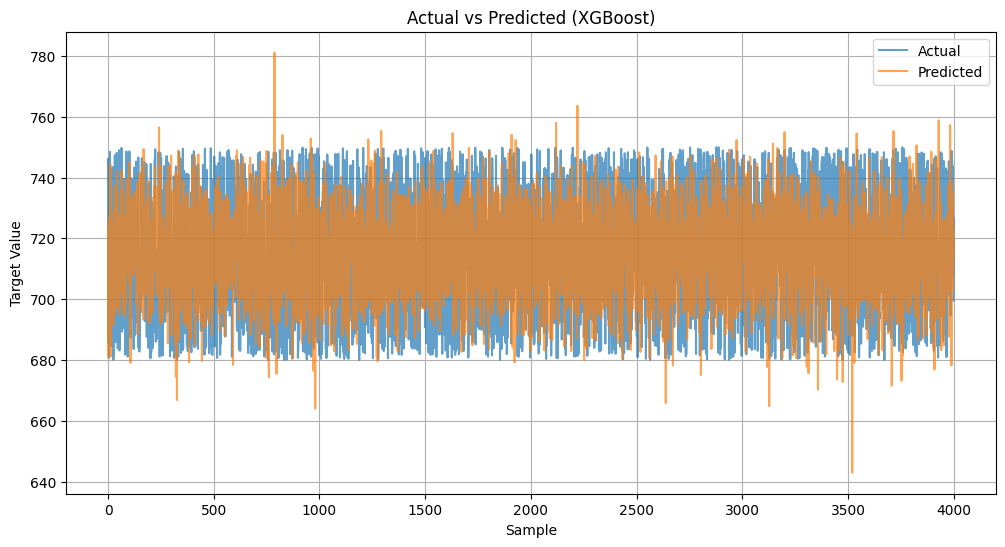

Results saved to 'test_results_xgboost.csv'


In [12]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the features
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Convert y_train and y_test to numpy arrays if needed
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test = y_test.values if isinstance(y_test, pd.Series) else y_test

# Scale the target values
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.5,
    max_depth=15,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model
xgb_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
yhat_scaled = xgb_model.predict(X_test_scaled)

# Inverse transform predictions to original scale
inv_yhat = target_scaler.inverse_transform(yhat_scaled.reshape(-1, 1)).flatten()
inv_y = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print(f'Test RMSE (XGBoost): {rmse:.3f}')


# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(inv_y, label='Actual', alpha=0.7)
plt.plot(inv_yhat, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted (XGBoost)')
plt.xlabel('Sample')
plt.ylabel('Target Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Store the results in a CSV file
results_df_xgb = pd.DataFrame({
    'Actual': inv_y,
    'Predicted': inv_yhat
})
results_df_xgb.to_csv('test_results_xgboost.csv', index=False)
print("Results saved to 'test_results_xgboost.csv'")
